In [160]:
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from stepmix.stepmix import StepMix

In [162]:
df = pd.read_csv("GermanCredit.csv")

In [164]:
df.head()

,Unnamed: 0,Duration,Amount,InstallmentRatePercentage,ResidenceDuration,Age,NumberExistingCredits,NumberPeopleMaintenance,Telephone,ForeignWorker,...,OtherInstallmentPlans.Bank,OtherInstallmentPlans.Stores,OtherInstallmentPlans.None,Housing.Rent,Housing.Own,Housing.ForFree,Job.UnemployedUnskilled,Job.UnskilledResident,Job.SkilledEmployee,Job.Management.SelfEmp.HighlyQualified
0,1,6,1169,4,4,67,2,1,0,1,...,0,0,1,0,1,0,0,0,1,0
1,2,48,5951,2,2,22,1,1,1,1,...,0,0,1,0,1,0,0,0,1,0
2,3,12,2096,2,3,49,1,2,1,1,...,0,0,1,0,1,0,0,1,0,0
3,4,42,7882,2,4,45,1,2,1,1,...,0,0,1,0,0,1,0,0,1,0
4,5,24,4870,3,4,53,2,2,1,1,...,0,0,1,0,0,1,0,0,1,0


# Part 1

## Data Pre-Processing For LCA

In [168]:
df = df.drop(columns = ["Unnamed: 0", "Class","Duration", "Amount","Age"])

In [170]:
df.columns

Index(['InstallmentRatePercentage', 'ResidenceDuration',
       'NumberExistingCredits', 'NumberPeopleMaintenance', 'Telephone',
       'ForeignWorker', 'CheckingAccountStatus.lt.0',
       'CheckingAccountStatus.0.to.200', 'CheckingAccountStatus.gt.200',
       'CheckingAccountStatus.none', 'CreditHistory.NoCredit.AllPaid',
       'CreditHistory.ThisBank.AllPaid', 'CreditHistory.PaidDuly',
       'CreditHistory.Delay', 'CreditHistory.Critical', 'Purpose.NewCar',
       'Purpose.UsedCar', 'Purpose.Furniture.Equipment',
       'Purpose.Radio.Television', 'Purpose.DomesticAppliance',
       'Purpose.Repairs', 'Purpose.Education', 'Purpose.Vacation',
       'Purpose.Retraining', 'Purpose.Business', 'Purpose.Other',
       'SavingsAccountBonds.lt.100', 'SavingsAccountBonds.100.to.500',
       'SavingsAccountBonds.500.to.1000', 'SavingsAccountBonds.gt.1000',
       'SavingsAccountBonds.Unknown', 'EmploymentDuration.lt.1',
       'EmploymentDuration.1.to.4', 'EmploymentDuration.4.to.7',
    

In [172]:
print(df.dtypes)

InstallmentRatePercentage                 int64
ResidenceDuration                         int64
NumberExistingCredits                     int64
NumberPeopleMaintenance                   int64
Telephone                                 int64
ForeignWorker                             int64
CheckingAccountStatus.lt.0                int64
CheckingAccountStatus.0.to.200            int64
CheckingAccountStatus.gt.200              int64
CheckingAccountStatus.none                int64
CreditHistory.NoCredit.AllPaid            int64
CreditHistory.ThisBank.AllPaid            int64
CreditHistory.PaidDuly                    int64
CreditHistory.Delay                       int64
CreditHistory.Critical                    int64
Purpose.NewCar                            int64
Purpose.UsedCar                           int64
Purpose.Furniture.Equipment               int64
Purpose.Radio.Television                  int64
Purpose.DomesticAppliance                 int64
Purpose.Repairs                         

In [174]:
df["Housing.ForFree"]

0      0
1      0
2      0
3      1
4      1
      ..
995    0
996    0
997    0
998    1
999    0
Name: Housing.ForFree, Length: 1000, dtype: int64

In [176]:
# List of the columns you are interested in
columns_of_interest = [
    'Purpose.NewCar', 'Purpose.UsedCar', 'Purpose.Furniture.Equipment',
    'Purpose.Radio.Television', 'Purpose.DomesticAppliance',
    'Purpose.Repairs', 'Purpose.Education', 'Purpose.Vacation'
]

# Check if any row has two or more 1's across these columns
df_with_multiple_ones = df[columns_of_interest].sum(axis=1) >= 2

# Filter rows where the condition is True
rows_with_multiple_ones = df[df_with_multiple_ones]

# Display the rows
print(rows_with_multiple_ones)

Empty DataFrame
Columns: [InstallmentRatePercentage, ResidenceDuration, NumberExistingCredits, NumberPeopleMaintenance, Telephone, ForeignWorker, CheckingAccountStatus.lt.0, CheckingAccountStatus.0.to.200, CheckingAccountStatus.gt.200, CheckingAccountStatus.none, CreditHistory.NoCredit.AllPaid, CreditHistory.ThisBank.AllPaid, CreditHistory.PaidDuly, CreditHistory.Delay, CreditHistory.Critical, Purpose.NewCar, Purpose.UsedCar, Purpose.Furniture.Equipment, Purpose.Radio.Television, Purpose.DomesticAppliance, Purpose.Repairs, Purpose.Education, Purpose.Vacation, Purpose.Retraining, Purpose.Business, Purpose.Other, SavingsAccountBonds.lt.100, SavingsAccountBonds.100.to.500, SavingsAccountBonds.500.to.1000, SavingsAccountBonds.gt.1000, SavingsAccountBonds.Unknown, EmploymentDuration.lt.1, EmploymentDuration.1.to.4, EmploymentDuration.4.to.7, EmploymentDuration.gt.7, EmploymentDuration.Unemployed, Personal.Male.Divorced.Seperated, Personal.Female.NotSingle, Personal.Male.Single, Personal.Mal

In [178]:
def assign_account_status(row):
    if row['CheckingAccountStatus.none'] == 1:
        return 1
    elif row['CheckingAccountStatus.lt.0'] == 1:
        return 2
    elif row['CheckingAccountStatus.0.to.200'] == 1:
        return 3
    elif row['CheckingAccountStatus.gt.200'] == 1:
        return 4
    else:
        return np.nan  # In case no condition is met (optional)

# Apply the function row-wise
df['CheckingAccountStatus'] = df.apply(assign_account_status, axis=1)

# Drop the old columns
df.drop(columns=['CheckingAccountStatus.lt.0', 'CheckingAccountStatus.0.to.200', 
                 'CheckingAccountStatus.gt.200', 'CheckingAccountStatus.none'], inplace=True)


In [180]:
def assign_credit_status(row):
    if row['CreditHistory.PaidDuly'] == 1:
        return 1
    elif row['CreditHistory.Delay'] == 1:
        return 2
    elif row['CreditHistory.Critical'] == 1:
        return 3
    elif row['CreditHistory.NoCredit.AllPaid']==1:
        return 4
    elif row['CreditHistory.ThisBank.AllPaid']==1:
        return 4 # all paid can just be one level so we can include it in our LCA analysis with other variables with 4 levels 
    else:
        return np.nan  # In case no condition is met (optional)

# Apply the function row-wise
df['CreditHistory'] = df.apply(assign_credit_status, axis=1)

# Drop the old columns
df.drop(columns=['CreditHistory.PaidDuly', 'CreditHistory.Delay', 
                 'CreditHistory.Critical', 'CreditHistory.NoCredit.AllPaid',
                 'CreditHistory.ThisBank.AllPaid'], inplace=True)


In [182]:
# Define a function to apply if-else logic for this set of columns
def assign_purpose(row):
    if row['Purpose.NewCar'] == 1:
        return 1
    elif row['Purpose.UsedCar'] == 1:
        return 2
    elif row['Purpose.Furniture.Equipment'] == 1:
        return 3
    elif row['Purpose.Radio.Television'] == 1:
        return 4
    elif row['Purpose.DomesticAppliance'] == 1:
        return 5
    elif row['Purpose.Repairs'] == 1:
        return 6
    elif row['Purpose.Education'] == 1:
        return 7
    elif row['Purpose.Vacation'] == 1:
        return 8
    elif row['Purpose.Retraining'] == 1:
        return 9
    elif row['Purpose.Business'] == 1:
        return 10
    elif row['Purpose.Other'] == 1:
        return 11
    else:
        return np.nan  # In case no condition is met (optional)

# Apply the function row-wise
df['Purpose'] = df.apply(assign_purpose, axis=1)




In [184]:
# Drop the old columns
df.drop(columns=[col for col in df.columns if col.startswith('Purpose.')], inplace=True)

In [186]:
def assign_savings_status(row):
    if row['SavingsAccountBonds.lt.100'] == 1:
        return 1
    elif row['SavingsAccountBonds.100.to.500'] == 1:
        return 2
    elif row['SavingsAccountBonds.500.to.1000'] == 1:
        return 3
    elif row['SavingsAccountBonds.gt.1000'] == 1:
        return 4
    elif row['SavingsAccountBonds.Unknown'] == 1:
        return 5
    else:
        return np.nan  # In case no condition is met (optional)
    
df['Savings'] = df.apply(assign_savings_status, axis=1)

In [188]:
# Drop the old columns
df.drop(columns=[col for col in df.columns if col.startswith('SavingsAccountBonds.')], inplace=True)

In [190]:
def assign_employment_status(row):
    if row['EmploymentDuration.lt.1'] == 1:
        return 1
    elif row['EmploymentDuration.1.to.4'] == 1:
        return 2
    elif row['EmploymentDuration.4.to.7'] == 1:
        return 3
    elif row['EmploymentDuration.gt.7'] == 1:
        return 4
    elif row['EmploymentDuration.Unemployed'] == 1:
        return 5
    else:
        return np.nan  # In case no condition is met (optional)

# Apply the function row-wise
df['EmploymentStatus'] = df.apply(assign_employment_status, axis=1)

# Drop the old columns
df.drop(columns=[col for col in df.columns if col.startswith('EmploymentDuration.')], inplace=True)


In [192]:
def assign_personal_status(row):
    if row['Personal.Male.Divorced.Seperated'] == 1:
        return 1
    elif row['Personal.Female.NotSingle'] == 1:
        return 2
    elif row['Personal.Male.Single'] == 1:
        return 3
    elif row['Personal.Male.Married.Widowed'] == 1:
        return 4
    elif row['Personal.Female.Single'] == 1:
        return 5 # there is no entry for level 5 so this variable essentially has 4 levels only and can be considered for LCA
    else:
        return np.nan  # In case no condition is met (optional)

# Apply the function row-wise
df['PersonalStatus'] = df.apply(assign_personal_status, axis=1)

# Drop the old columns
df.drop(columns=[col for col in df.columns if col.startswith('Personal.')], inplace=True)


In [194]:
def assign_debtors_guarantors_status(row):
    if row['OtherDebtorsGuarantors.None'] == 1:
        return 1
    elif row['OtherDebtorsGuarantors.CoApplicant'] == 1:
        return 2
    elif row['OtherDebtorsGuarantors.Guarantor'] == 1:
        return 3
    else:
        return np.nan

# Apply the function row-wise
df['OtherDebtors'] = df.apply(assign_debtors_guarantors_status, axis=1)

# Drop the old columns
df.drop(columns=[col for col in df.columns if col.startswith('OtherDebtorsGuarantors.')], inplace=True)


In [196]:
def assign_property_status(row):
    if row['Property.RealEstate'] == 1:
        return 1
    elif row['Property.Insurance'] == 1:
        return 2
    elif row['Property.CarOther'] == 1:
        return 3
    elif row['Property.Unknown'] == 1:
        return 4
    else:
        return np.nan

# Apply the function row-wise
df['PropertyStatus'] = df.apply(assign_property_status, axis=1)

# Drop the old columns
df.drop(columns=[col for col in df.columns if col.startswith('Property.')], inplace=True)

In [198]:
def assign_installment_plans_status(row):
    if row['OtherInstallmentPlans.Bank'] == 1:
        return 1
    elif row['OtherInstallmentPlans.Stores'] == 1:
        return 2
    elif row['OtherInstallmentPlans.None'] == 1:
        return 3
    else:
        return np.nan

# Apply the function row-wise
df['InstallmentPlansStatus'] = df.apply(assign_installment_plans_status, axis=1)

# Drop the old columns
df.drop(columns=[col for col in df.columns if col.startswith('OtherInstallmentPlans.')], inplace=True)


In [200]:
def assign_housing_status(row):
    if row['Housing.Rent'] == 1:
        return 1
    elif row['Housing.Own'] == 1:
        return 2
    elif row['Housing.ForFree'] == 1:
        return 3
    else:
        return np.nan

# Apply the function row-wise
df['HousingStatus'] = df.apply(assign_housing_status, axis=1)

# Drop the old columns
df.drop(columns=[col for col in df.columns if col.startswith('Housing.')], inplace=True)

In [202]:
def assign_job_status(row):
    if row['Job.UnemployedUnskilled'] == 1:
        return 1
    elif row['Job.UnskilledResident'] == 1:
        return 2
    elif row['Job.SkilledEmployee'] == 1:
        return 3
    elif row['Job.Management.SelfEmp.HighlyQualified'] == 1:
        return 4
    else:
        return np.nan

# Apply the function row-wise
df['JobStatus'] = df.apply(assign_job_status, axis=1)

# Drop the old columns
df.drop(columns=[col for col in df.columns if col.startswith('Job.')], inplace=True)



In [204]:
df.columns

Index(['InstallmentRatePercentage', 'ResidenceDuration',
       'NumberExistingCredits', 'NumberPeopleMaintenance', 'Telephone',
       'ForeignWorker', 'CheckingAccountStatus', 'CreditHistory', 'Purpose',
       'Savings', 'EmploymentStatus', 'PersonalStatus', 'OtherDebtors',
       'PropertyStatus', 'InstallmentPlansStatus', 'HousingStatus',
       'JobStatus'],
      dtype='object')

In [206]:
df.columns[df.isna().any()] # no na's

Index([], dtype='object')

In [208]:
df.head()

,InstallmentRatePercentage,ResidenceDuration,NumberExistingCredits,NumberPeopleMaintenance,Telephone,ForeignWorker,CheckingAccountStatus,CreditHistory,Purpose,Savings,EmploymentStatus,PersonalStatus,OtherDebtors,PropertyStatus,InstallmentPlansStatus,HousingStatus,JobStatus
0,4,4,2,1,0,1,2,3,4,5,4,3,1,1,3,2,3
1,2,2,1,1,1,1,3,1,4,1,2,2,1,1,3,2,3
2,2,3,1,2,1,1,1,3,7,1,3,3,1,1,3,2,2
3,2,4,1,2,1,1,2,1,3,1,3,3,3,2,3,3,3
4,3,4,2,2,1,1,2,2,1,1,2,3,1,4,3,3,3


## Question 1

## Picking categorical variables that are relevant to the business problem and that have the same levels for improved performance

### The variables picked and what their different levels mean: 



### 1. Checkings Account History - 
### Level 1 = No Checking Account
### Level 2 = Less than 0 DM
### Level 3 = 0 - 200 DM
### Level 4 = Greater than 200 DM



### 2. Personal Status - 
### Level 1 = Male, divorced/separated
### Level 2 = Female, divorced/separated/married
### Level 3 = Male, single
### Level 4 = Male, married/widowed



### 3. Property Status - 
### Level 1 = Real Estate
### Level 2 = Building society savings agreement/ life insurance
### Level 3 = Car or other
### Level 4 = Unknown/No Property



### 4. Job Status - 
### Level 1 = Unemployed/unskilled, non-resident
### Level 2 = Unskilled, resident
### Level 3 = Skilled employee / Official
### Level 4 = Management/self-employed/highly qualified employee/officer



### 5. Credit History - 
### Level 1 = Existing credits paid back duly till now
### Level 2 = Delay in paying off in the past
### Level 3 = Critical account/other credits existing (not at this bank)
### Level 4 = All credits paid/no credit left

In [213]:
categorical_cols = [
    "CheckingAccountStatus", "CreditHistory",
    "PersonalStatus", "PropertyStatus", "JobStatus"
]

for col in categorical_cols:
    df[col] = df[col].astype("category")  
    df[col] = df[col].cat.codes + 1  

print(df[categorical_cols].head())

   CheckingAccountStatus  CreditHistory  PersonalStatus  PropertyStatus  \
0                      2              3               3               1   
1                      3              1               2               1   
2                      1              3               3               1   
3                      2              1               3               2   
4                      2              2               3               4   

   JobStatus  
0          3  
1          3  
2          2  
3          3  
4          3  


In [215]:
# Convert categorical columns to numpy array for StepMix
X = df[categorical_cols].to_numpy()

# Train-Test Split (70% train, 30% test)
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

## Question 2

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 50/50 [00:11<00:00,  4.20it/s, max_LL=-3.99e+3, max_avg_LL=-5.7]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 50/50 [00:09<00:00,  5.52it/s, max_LL=-3.96e+3, max_avg_LL=-5.65]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 50/50 [00:13<00:00,  3.66it/s, max_LL=-3.93e+3, max_avg_LL=-5.61]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 50/50 [00:13<00:00,  3.60it/s, max_LL=-3.91e+3, max_avg_LL=-5.59]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 50/50 [00:14<00:00,  3.54it/s, max_LL=-3.9e+3, max_avg_LL=-5.57]


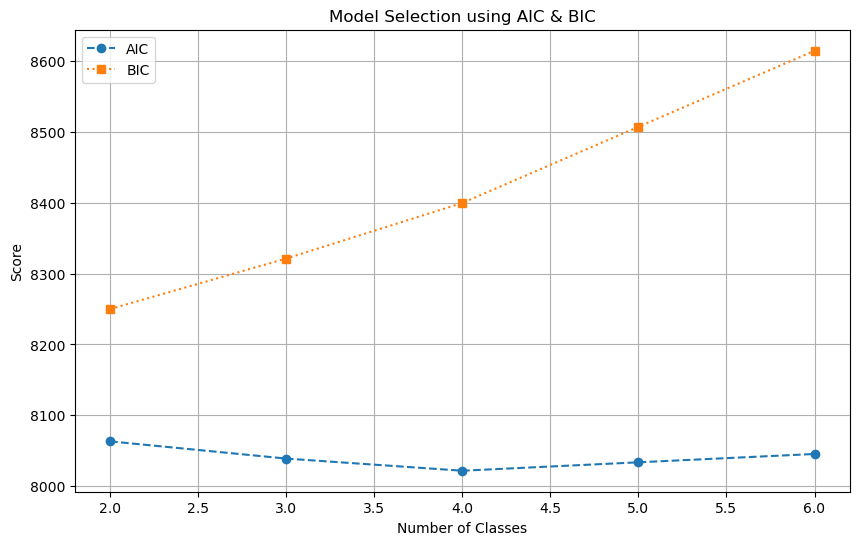

In [217]:
aic_scores = []
bic_scores = []
models = []
K_values = range(2, 7)  # Test 2-5 classes

for K in K_values:
    # Fit model with multiple random starts
    model = StepMix(
        n_components=K,
        measurement='categorical',
        n_init=50,
        max_iter=1000,
        random_state=42
    )
    model.fit(X_train)
    
    # Calculate AIC and BIC using the fitted model
    aic = model.aic(X_train)
    bic = model.bic(X_train)

    aic_scores.append(aic)
    bic_scores.append(bic)
    models.append(model)

# Plot AIC & BIC for model selection
plt.figure(figsize=(10, 6))
plt.plot(K_values, aic_scores, marker='o', label="AIC", linestyle='dashed')
plt.plot(K_values, bic_scores, marker='s', label="BIC", linestyle='dotted')
plt.xlabel('Number of Classes')
plt.ylabel('Score')
plt.title('Model Selection using AIC & BIC')
plt.legend()
plt.grid(True)
plt.show()

## We picked 3 as our optimal number of classes based on the AIC and BIC scores.

## Question 3

In [219]:
# Train LCA model on the training set
train_model = StepMix(
    n_components=3,
    measurement='categorical',
    n_init=50,  
    max_iter=1000,  
    random_state=42
)
train_model.fit(X_train)

# Extract class-conditional probabilities 
train_params = train_model.get_parameters()

# Initialize a new LCA model for the test set
test_model = StepMix(
    n_components=3,
    measurement='categorical',
    n_init=1,  
    max_iter=500,  
    random_state=42
)

# Set the learned parameters from the training model
test_model.set_parameters(train_params)

# Fit the test model without reinitializing (it starts from train's parameters)
test_model.fit(X_test)

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 50/50 [00:09<00:00,  5.46it/s, max_LL=-3.96e+3, max_avg_LL=-5.65]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00, 12.43it/s, max_LL=-1.67e+3, max_avg_LL=-5.56]


StepMix(max_iter=500, measurement='categorical', n_components=3,
        random_state=42)

In [221]:
# Compare class sizes (proportions) for Train vs Test
train_class_sizes = np.round(train_model.weights_, 3)
test_class_sizes = np.round(test_model.weights_, 3)

print("Class Proportions (Train):", train_class_sizes)
print("Class Proportions (Test):", test_class_sizes)

Class Proportions (Train): [0.427 0.283 0.291]
Class Proportions (Test): [0.276 0.405 0.319]


In [223]:
similarity_avg = np.mean(np.abs(train_class_sizes - test_class_sizes))
similarity = np.abs(train_class_sizes - test_class_sizes)

print("\nAverage Difference in Conditional Class Sizes:", round(similarity_avg,4))

print("\nDifference in Conditional Class Sizes:", similarity)


Average Difference in Conditional Class Sizes: 0.1003

Difference in Conditional Class Sizes: [0.151 0.122 0.028]


## Given the difference in average class sizes is only about 0.1003, we consider the model to be stable. 

In [226]:
train_cond_probs = train_model.get_parameters()["measurement"]["pis"]
test_cond_probs = test_model.get_parameters()["measurement"]["pis"]

print("\nTrain Conditional Probabilities:\n", train_cond_probs)
print("\nTest Conditional Probabilities:\n", test_cond_probs)


Train Conditional Probabilities:
 [[1.00000000e-15 3.51844350e-01 3.02392027e-01 2.87571879e-01
  5.81917445e-02 1.00000000e-15 5.70279130e-01 7.71898931e-02
  3.02590381e-01 4.99405960e-02 1.00000000e-15 3.76475280e-02
  3.55399834e-01 4.32382912e-01 1.74569725e-01 1.00000000e-15
  5.31785819e-01 2.73768988e-01 1.94445192e-01 1.00000000e-15
  1.00000000e-15 2.07460788e-02 3.49553907e-01 6.24071322e-01
  5.62869195e-03]
 [1.00000000e-15 7.27660761e-08 4.73631710e-01 4.52218403e-01
  7.41498135e-02 1.00000000e-15 4.80625110e-01 9.90160488e-02
  1.83389978e-01 2.36968863e-01 1.00000000e-15 7.63226699e-02
  3.43220492e-01 5.60504163e-01 1.99526752e-02 1.00000000e-15
  7.53480717e-02 2.15875070e-01 3.72565414e-01 3.36211445e-01
  1.00000000e-15 4.45095933e-02 7.85955164e-02 5.71626804e-01
  3.05268087e-01]
 [1.00000000e-15 8.34832189e-01 2.54997430e-11 1.06437554e-01
  5.87302574e-02 1.00000000e-15 4.50075143e-01 1.09866670e-01
  4.14433942e-01 2.56242447e-02 1.00000000e-15 1.30677227e-02

In [228]:
similarity = np.mean(np.abs(train_cond_probs - test_cond_probs))
print("\nAverage Difference in Conditional Probabilities:", round(similarity, 4))


Average Difference in Conditional Probabilities: 0.1004


## Given the average difference in conditional probabilities is only about 0.1004, we consider the model to be stable. 

# Question 4

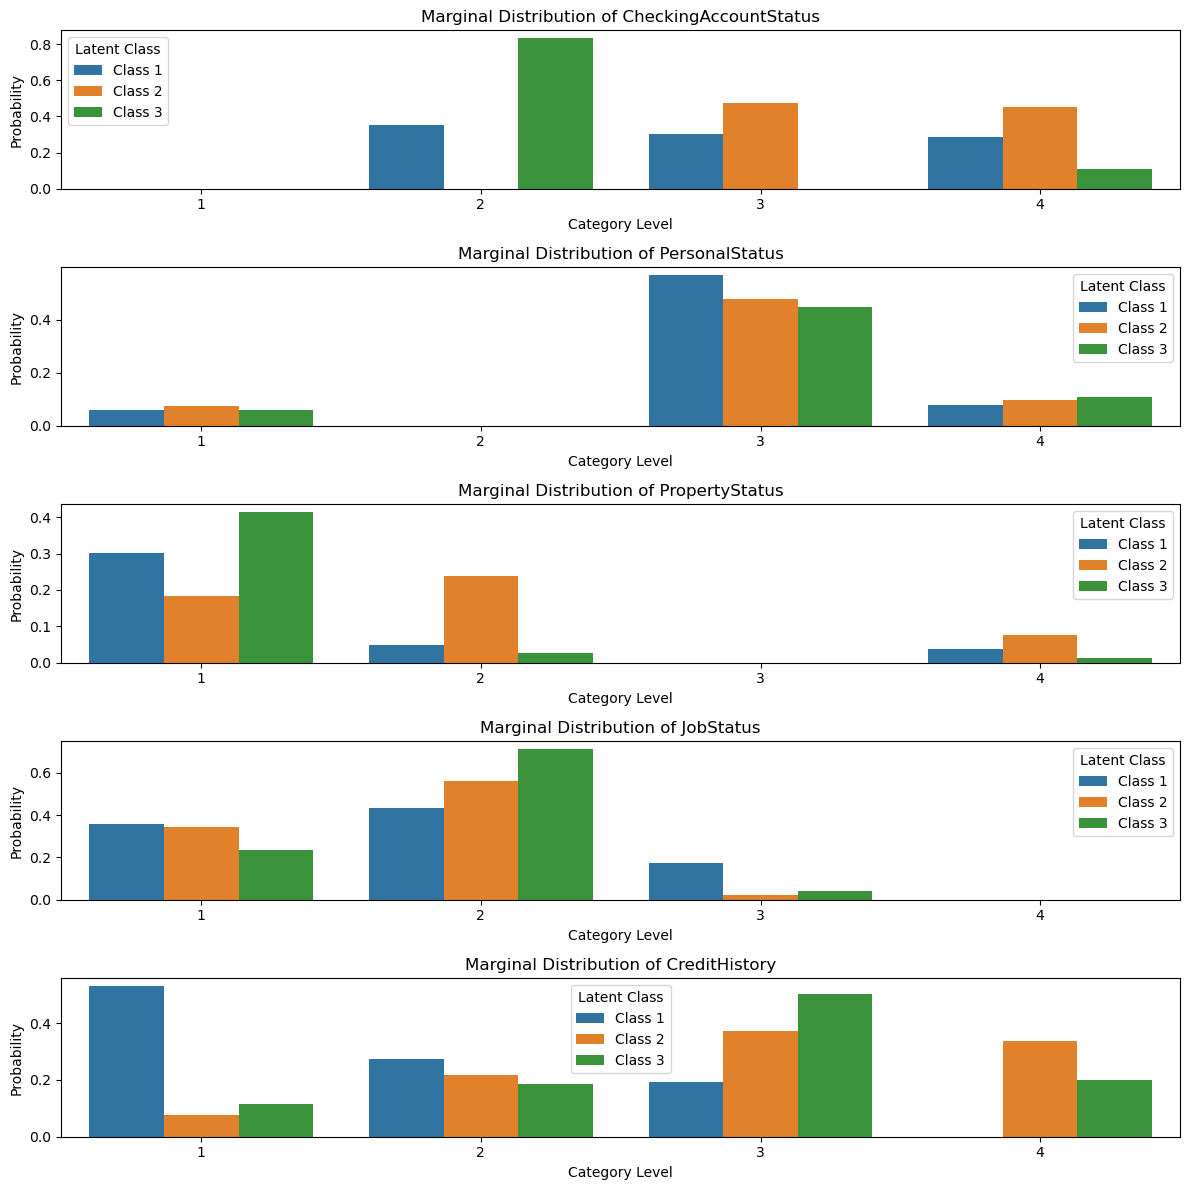

In [263]:
# Extract probabilities 
params = train_model.get_parameters()

# StepMix outputs all probabilities in a single matrix, so we need to reshape it
num_categories = [4, 4, 4, 4, 4]  # Levels per categorical variable (all 4-level)
num_classes = 3  # Number of latent classes
prob_df = {}

start_idx = 0  # Track start position in the pis matrix

for i, col in enumerate(categorical_cols):
    num_levels = num_categories[i]  # Get levels for the variable

    # Extract class probabilities for this variable
    prob_matrix = pis_matrix[:, start_idx : start_idx + num_levels].T  # Transpose for plotting

    # Convert to DataFrame
    prob_df[col] = pd.DataFrame(prob_matrix, columns=[f"Class {j+1}" for j in range(num_classes)])
    prob_df[col]['Category'] = np.arange(1, num_levels + 1)  
    start_idx += num_levels  # Move index forward

# Plot marginal distributions
fig, axes = plt.subplots(5, 1, figsize=(12, 12))

for ax, col in zip(axes.flatten(), categorical_cols):
    if col not in prob_df:
        continue  # Skip missing categories

    df_plot = prob_df[col].melt(id_vars=['Category'], var_name="Class", value_name="Probability")

    sns.barplot(x="Category", y="Probability", hue="Class", data=df_plot, ax=ax)
    ax.set_title(f"Marginal Distribution of {col}")
    ax.set_xlabel("Category Level")
    ax.set_ylabel("Probability")
    ax.legend(title="Latent Class")

plt.tight_layout()
plt.show()

### Some levels don’t appear in the plot because StepMix sometimes assigns extremely small probabilities (close to 0), making them invisible.

## Class 1 "Financially Responsible Young Singles":
### * High probability of having small balance (0-200 DM)
### * Most likely to be single males
### * Strong tendency to own real estate
### * Mix of unemployment and skilled employment
### * Very strong history of paying credits duly
### This appears to be likely younger single males who are building their career, have good credit discipline, and have invested in real estate.

<br>

## Class 2 "Credit-Dependent Working Class":
### * Typically has moderate to high checking account balances
### * Primarily single males again
### * More likely to have building society savings/life insurance along with real estate
### * Highest probability of being unskilled resident workers
### * Higher chance of having critical accounts or existing credits at other banks
### This seems to be working individuals who rely more heavily on credit and may struggle with managing multiple credit obligations.

<br>

## Class 3 "Cash-Strapped Property Owners”:
### * Very high probability of negative checking account balance
### * Higher proportion of single males
### * High probability of real estate ownership
### * Highest proportion of unskilled resident workers
### * Strong tendency toward critical accounts/other existing credits
### This appears to be individuals who own property but struggle with cash flow and credit management.

# Question 5

### The task of naming these classes was moderately challenging for several reasons:
### 1. There’s overlap in some characteristics across classes. For example, most individuals across classes are single males who are unskilled residents
### 2. Some patterns seem counterintuitive like having real estate but negative account balances
### 3. The relationships between variables aren't always clearly aligned in a way that suggests obvious archetypal profile with some variables showing similar patterns across classes, making it harder to find truly distinguishing characteristics